<a href="https://colab.research.google.com/github/mario-dg/KI-Gruppe-03/blob/eda-jonathan/AI_COV_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA
- "A worldwide epidemiological database for COVID-19 at finegrained spatial resolution" - 2022, Guidotti
- [data origin](https://covid19datahub.io/articles/data.html)
- [docs](https://covid19datahub.io/articles/docs.html)

## TODO/NOTES
- maybe look into the rows where administrative_area_level_2 and administrative_area_level_3 are null because they might have a meaning (nation wide restrictions or something like that)
- outlier detection
- plot some cool looking maps
- time series analysis

## importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install geopandas
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns

In [ ]:
#df = pd.read_csv("DEU.csv")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ai_covid-19/DEU.csv")
#df = pd.read_csv("https://storage.covid19datahub.io/country/DEU.csv")
# df with only epidemiological variables
epi_features = list(df.columns[2:12])
epi_features.append('population')
epi_df = df[epi_features]


# df with only policy measures
policy_features = list(df.columns[12:26])
policy_df = df[policy_features]

<ipython-input-91-5fd016b09700>:2: DtypeWarning: Columns (33,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ai_covid-19/DEU.csv")


## functions

In [ ]:
# bundesland
def get_df_by_fed_state(fed_state, df):
  return df[df['administrative_area_level_2']==fed_state]
  
# landkreis
def get_df_by_fed_state(district, df):
  return df[df['administrative_area_level_3']==district]

## general inspection

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
# Count by id
counts = df['id'].value_counts()
print('number of unique ids: '+str(len(counts)))

number of unique ids: 429


In [ ]:
# Count by id
counts = df['longitude'].value_counts()
print('number of unique longitude values: '+str(len(counts)))

number of unique longitude values: 416


In [ ]:
# Count by administrative_area_level_3
counts = df['administrative_area_level_3'].value_counts()
print('number of unique administrative_area_levels_3: '+str(len(counts)))

number of unique administrative_area_levels_3: 412


In [ ]:
# Count the number of unique values in each column
unique_counts = df.nunique()

# Print the counts
print(unique_counts)

In [ ]:
# Filter for columns with object data type
obj_cols = df.select_dtypes(include=['object']).columns
df_obj = df[obj_cols]
# Filter for columns with float data type
float_cols = df.select_dtypes(include=['float64']).columns
df_float = df[float_cols]

## data preprocessing

In [ ]:
def drop_keys(df):
  cols = ['key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm']
  df = df.drop(cols ,axis=1)
  return df
def drop_indices(df):
  cols = ['government_response_index', 'stringency_index', 'containment_health_index', 'economic_support_index']
  df = df.drop(cols ,axis=1)
  return df
  
#drop key values (for now)
processed_df = drop_keys(df)

#drop indices (for now)
processed_df = drop_indices(processed_df)

#drop unimportant columns
processed_df = processed_df.drop(['hosp', 'vent', 'icu', 'tests' , 'iso_alpha_3', 'iso_alpha_2', 'iso_currency', 'iso_numeric'],axis=1)
epi_features = [x for x in epi_features if x != 'hosp']
epi_features = [x for x in epi_features if x != 'vent']
epi_features = [x for x in epi_features if x != 'icu']
epi_features = [x for x in epi_features if x != 'tests']

#drop 4%~ of columns where almost all policies values are empty
processed_df = processed_df.dropna(subset=['workplace_closing'])

# change categorical values from to int
for col in policy_df:
  processed_df[col] = processed_df[col].astype(int)

# change date string to datetime obj
processed_df['date'] = pd.to_datetime(processed_df['date'])

# set date threshold
date_threshold = '2020-12-27'

# convert certain values from NaN to 0
processed_df.loc[processed_df['date'] < date_threshold, 'vaccines'] = 0
processed_df.loc[processed_df['date'] < date_threshold, 'people_vaccinated'] = 0
processed_df.loc[processed_df['date'] < date_threshold, 'people_fully_vaccinated'] = 0

# fill the rest of the nan values
processed_df['vaccines'].fillna(method='ffill', inplace = True)
processed_df['people_vaccinated'].fillna(method='ffill', inplace = True)
processed_df['people_fully_vaccinated'].fillna(method='ffill', inplace = True)
processed_df['recovered'].fillna(method='ffill', inplace = True)
processed_df['deaths'].fillna(method='ffill', inplace = True)
processed_df['confirmed'].fillna(method='ffill', inplace = True)
# unnecessarily computationally expensive (but it works)
#for id in unique_ids:
#  processed_df.loc[processed_df['id'] == id, 'vaccines'] = processed_df.loc[processed_df['id'] == id, 'vaccines'].fillna(method='ffill')
#  processed_df.loc[processed_df['id'] == id, 'people_vaccinated'] = processed_df.loc[processed_df['id'] == id, 'people_vaccinated'].fillna(method='ffill')
#  processed_df.loc[processed_df['id'] == id, 'people_fully_vaccinated'] = processed_df.loc[processed_df['id'] == id, 'people_fully_vaccinated'].fillna(method='ffill')

<ipython-input-194-a8206c8c375e>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[col] = processed_df[col].astype(int)


## missing values

In [ ]:
def plot_missing_values(df):
  # Calculate the count of missing values in each column
  missing_counts = df.isna().sum()
  missing_percentages = (missing_counts / len(df)) * 100

  # Drop columns with no missing values
  missing_counts = missing_counts[missing_counts != 0]
  missing_percentages = missing_percentages[missing_percentages != 0]

  # Sort columns by missing values in descending order
  sorted_columns = missing_counts.sort_values(ascending=False).index

  # Plot the missing value counts and percentages as a horizontal bar chart
  plt.figure(figsize=(10,8))
  plt.barh(sorted_columns, missing_counts[sorted_columns])
  for i, v in enumerate(missing_counts[sorted_columns]):
      plt.text(v, i,f" ({missing_percentages[sorted_columns][i]:.2f}%)", color='blue', fontweight='bold')
  plt.xlabel('Count of missing values')
  plt.ylabel('Columns')
  plt.title('Missing Value Counts in DataFrame')
  plt.show()

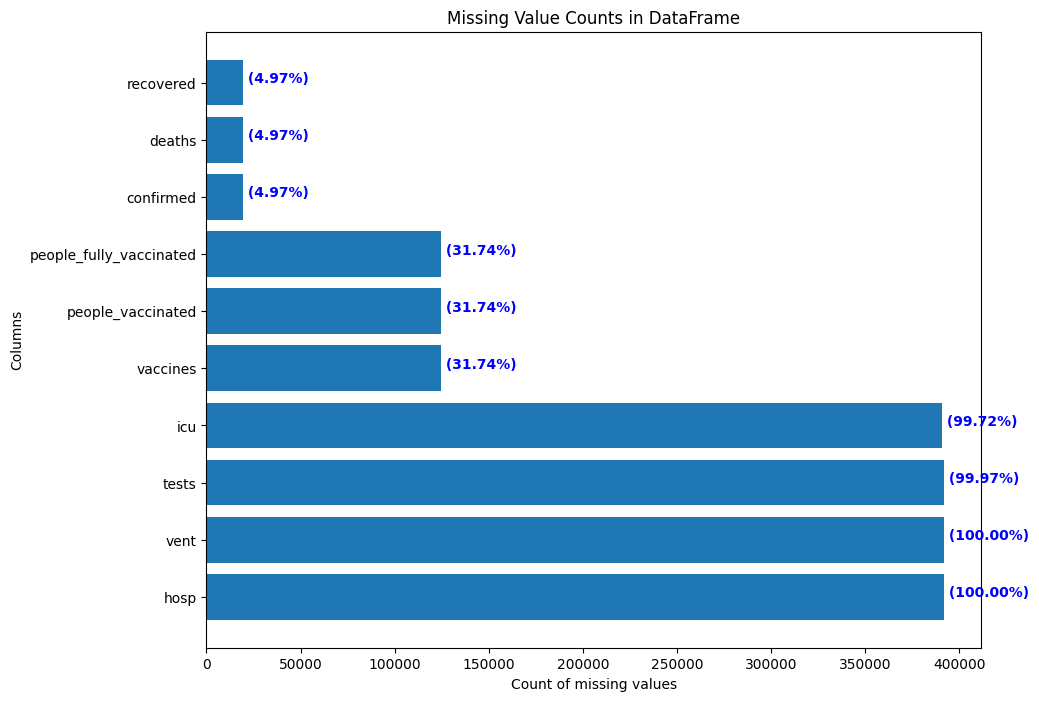

In [ ]:
plot_missing_values(epi_df)

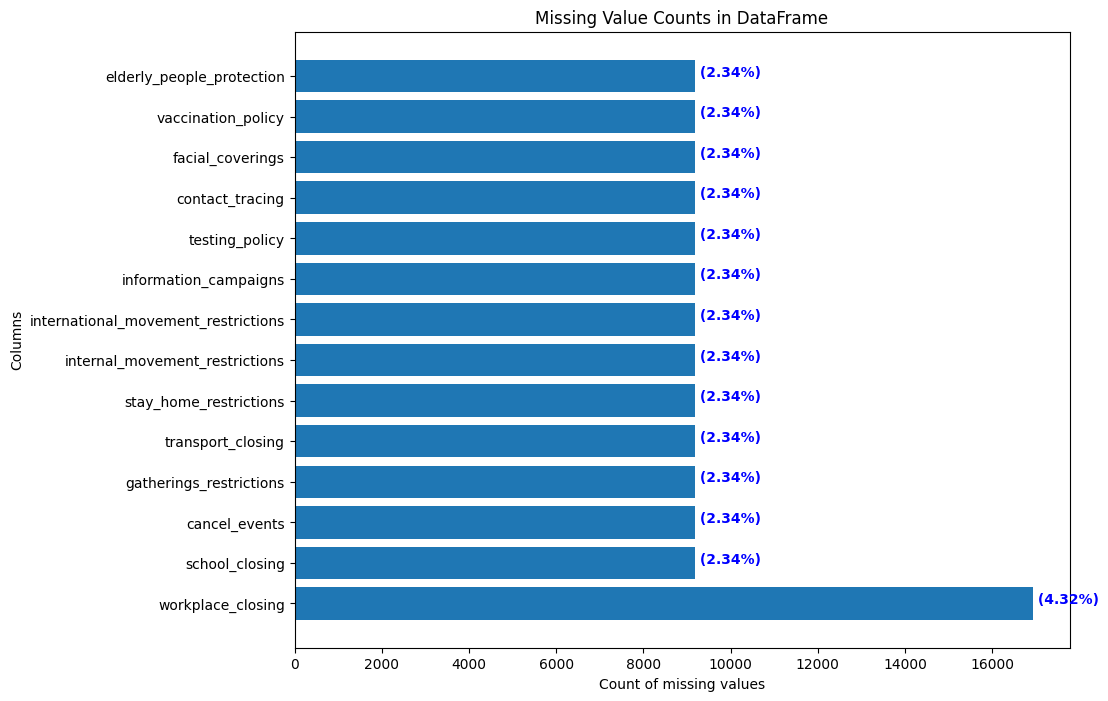

In [ ]:
plot_missing_values(df[policy_features])

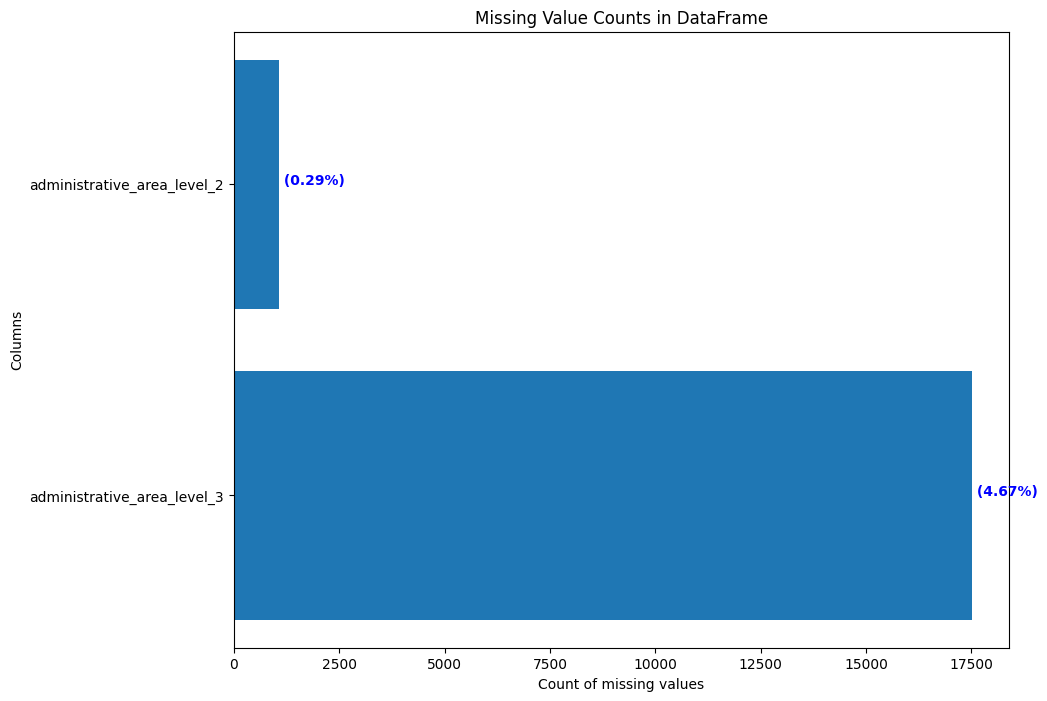

In [ ]:
plot_missing_values(processed_df)

### handle missing data

administrative_area_level_3 and administrative_area_level_2 are only empty when the restrictions were on a level above, because then the federal state or district doesn't matter

In [ ]:
nan_rows = processed_df[processed_df['administrative_area_level']==3]
nan_rows = nan_rows[nan_rows[['administrative_area_level_3']].isna().any(axis=1)]
#nan_rows = processed_df[processed_df[['administrative_area_level_3']].isna().any(axis=1)]
nan_rows = nan_rows[['administrative_area_level_3','administrative_area_level_2','administrative_area_level','id','date']]

In [ ]:
nan_rows

,administrative_area_level_3,administrative_area_level_2,administrative_area_level,id,date


## data distribution

In [ ]:
def plot_distribution(df):
  # Plot the distribution of each column
  for col in df.columns:
      plt.figure(figsize=(10,8))
      plt.hist(df[col].dropna(), bins=30)
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')
      plt.show()

In [ ]:
plot_distribution(processed_df[policy_features])

In [ ]:
plot_distribution(processed_df[epi_features])

## outliers
- maybe z-score
- maybe local outlier factor (need to take care of nan values before)

In [ ]:
def z_score(row):
    return (row - row.mean()) / row.std()

In [ ]:
# Apply the function to each row of the dataframe
z_scores = epi_df.apply(z_score, axis=1)

# Print the resulting Z-scores
print(z_scores)

        confirmed    deaths  recovered  tests  vaccines  people_vaccinated  \
0       -0.500000 -0.500000  -0.500000    NaN       NaN                NaN   
1       -0.500000 -0.500000  -0.500000    NaN       NaN                NaN   
2             NaN       NaN        NaN    NaN       NaN                NaN   
3       -0.500000 -0.500000  -0.500000    NaN       NaN                NaN   
4       -0.500000 -0.500000  -0.500000    NaN       NaN                NaN   
...           ...       ...        ...    ...       ...                ...   
392167  -0.498264 -1.059299  -0.500614    NaN  2.083143          -0.103537   
392168  -0.043911 -1.176522  -0.049003    NaN       NaN                NaN   
392169  -0.043824 -1.176553  -0.049032    NaN       NaN                NaN   
392170  -0.497820 -1.059396  -0.500710    NaN  2.083176          -0.103632   
392171  -0.497605 -1.059433  -0.500755    NaN  2.083197          -0.103682   

        people_fully_vaccinated  hosp  icu  vent  population  


In [ ]:
# Calculate the Z-score for each data point
z_scores = (processed_df['confirmed'] - np.mean(processed_df['confirmed'])) / np.std(processed_df['confirmed'])

# Create a Pandas Series with the Z-scores
z_scores_series = pd.Series(z_scores)

# Find any Z-score that is greater than 3 or less than -3
outliers = z_scores_series[(z_scores_series > 3) | (z_scores_series < -3)]

# Print the outliers, if any
if len(outliers) > 0:
    print("Outliers found:")
    print(outliers)
else:
    print("No outliers found.")

Outliers found:
439      3.008614
440      3.033002
441      3.051905
442      3.061175
443      3.073866
           ...   
18527    3.821096
18528    3.829035
18529    3.833569
18530    3.837906
18531    3.838704
Name: confirmed, Length: 1683, dtype: float64


## correlations

In [ ]:
temp = list(epi_features)
temp.append('vaccination_policy')
temp.append('transport_closing')
temp.append('gatherings_restrictions')

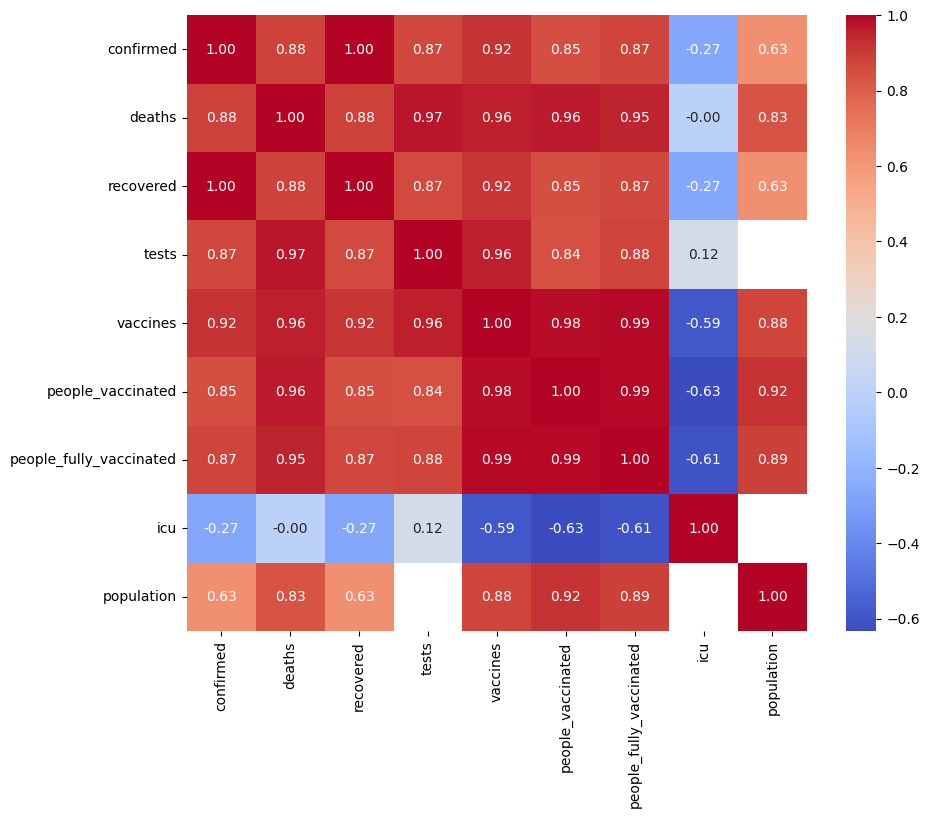

In [ ]:
# Compute correlation matrix
corr_matrix = processed_df[epi_features].corr()

# Create a new figure with size 10x8 inches
fig = plt.figure(figsize=(10, 8))

# Plot correlation matrix using Seaborn's heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show plot
plt.show()

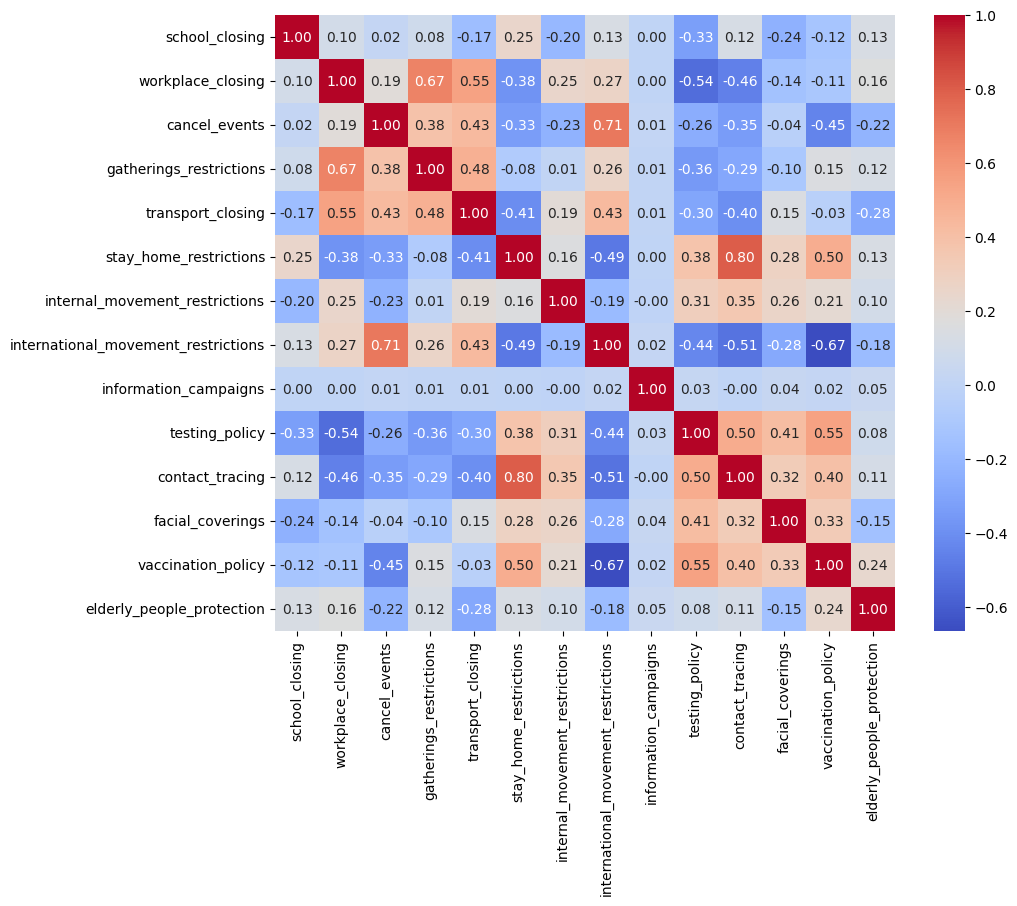

In [ ]:
# Compute correlation matrix
corr_matrix = processed_df[policy_features].corr()

# Create a new figure with size 10x8 inches
fig = plt.figure(figsize=(10, 8))

# Plot correlation matrix using Seaborn's heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show plot
plt.show()

## germany map
- https://juanitorduz.github.io/germany_plots/
- [data source](http://www.diva-gis.org/gdata)

In [ ]:
germany = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/ai_covid-19/DEU_adm/DEU_adm3.shp')

In [ ]:
geo_df = processed_df[['latitude', 'longitude']]
geo_df = geo_df.drop_duplicates(subset=['longitude', 'latitude'])

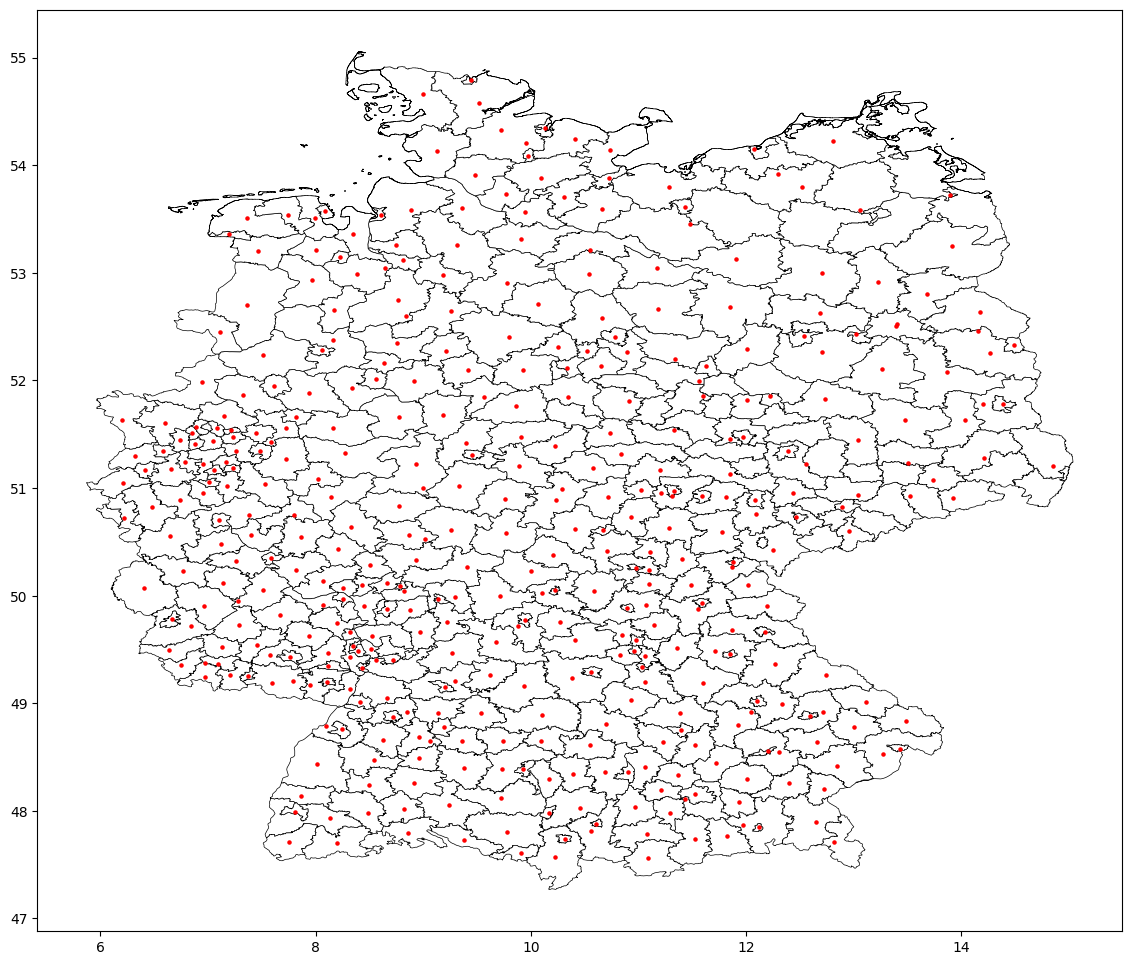

In [ ]:
# plot longitude and latitude on map
fig, ax = plt.subplots(figsize=(14, 18))
geometry = [Point(xy) for xy in zip(geo_df['longitude'], geo_df['latitude'])]
points_gdf = gpd.GeoDataFrame(geometry=geometry)

germany.plot(color='white', edgecolor='black', ax=ax, linewidth=0.5)
# Plot the map of Germany on the figure
points_gdf.plot(color='red', ax=ax, markersize=5)

plt.show()